In [1]:
#importing required modules

from pathlib import Path
from tempfile import NamedTemporaryFile
import fileinput
import os
import rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import gensim
from gensim.models import word2vec
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, LeaveOneOut, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ConstantKernel as C, RationalQuadratic
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import itertools
import statistics
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, RationalQuadratic, Matern
from rdkit.Chem import Descriptors


In [2]:
'''
Three functions that assist in converting lists to strings and vice versa.
These are helpful when storing vectors in csv files. 
'''


def str2float(string):
    split = list(string.split(','))
    floats_split = []
    for i in range(len(split)):
        floats = float(split[i])
        floats_split.append(floats)
    return floats_split

def stringToList(vectors):
    bracket_removed_mol2vec = []
    for i in range(len(vectors)):
        new_strings = vectors[i].replace('[', '')
        newer_strings = new_strings.replace(']', '')
        bracket_removed_mol2vec.append(newer_strings)

# Convert all vectors
    xList = []
    for i in range(len(bracket_removed_mol2vec)):
        float_vec = str2float(bracket_removed_mol2vec[i])
        xList.append(float_vec)
    
    return xList
    
def listToString(vectors):
    string_indices = []
    for i in range(len(vectors)):
        knn_string = ', '.join(str(k) for k in vectors[i])
        string_indices.append(knn_string)

    bracket_string_indices = []
    for i in range(len(string_indices)):
        bracket_string = '[' + string_indices[i] + ']'
        bracket_string_indices.append(bracket_string)
    
    return bracket_string_indices

In [3]:
def get_bootstrap_samples(data, n_samples, replace: bool = True, s = 228, noise_scale: float = 0.5):
    """
    Wrapper function to bootstrap column densities in a dataset.
    The idea here is to generate "new" data by sampling with
    replacement, and adding Gaussian noise to the log column
    densities. The scale of the noise is set by the parameter
    `noise_scale`.
    Parameters
    ----------
    data : Tuple[np.ndarray]
        2-tuple containing X (2D) and y (1D) NumPy arrays
    s : int
        Seed used to set the random state
    n_samples : int, optional
        Target dataset size, by default 500
    replace : bool, optional
        Whether to do bootstrapping with replacement, by default True
    noise_scale : float, optional
        Gaussian scale for target noise, by default 0.5
    Returns
    -------
    2-tuple
        boot_X is a 2D NumPy array of features with
        shape [N, L] where N = `n_samples`. boot_y
        is a NumPy 1D array with bootstrapped, noisy
        regression targets with shape [N].
    """
    boot_X, boot_y = resample(*data, n_samples=n_samples, replace=replace, random_state=s)
    rng = np.random.default_rng(s)
    boot_y += rng.normal(0., noise_scale, size=boot_y.size)
    return boot_X, boot_y

In [4]:
'''
This function takes the feature vectors and SMILES strings of the molecules 
that you want to predict the column density of. It then returns their scaled versions

Returns:

X_train_scaled: bootstrapped and scaled feature vectors in training set
y_train_boot: bootstrapped column densities in traning set
X_val_scaled: scaled feature vectors of molecules you want to predict
val_smiles: SMILES strings of molecules you want to predict

'''


def getIsoSplitsVal(X_val, val_smiles):
    fullPath = os.path.join(os.getcwd(), 'final_detections.csv')
    full = pd.read_csv(fullPath)
    smiles = list(full['smiles'])
    y = list(np.log10(np.array(list(full['N']))))
    x = stringToList(list(full['final vectors iso 70']))
    parent = list(full['parent 2'])
    
    parentSmiles = []
    parentY = []
    parentX = []
    
    isoSmiles = []
    isoY = []
    isoX = []
    isoParents = []
    
    for i in range(len(parent)):
        if parent[i] == "Main":
            parentSmiles.append(smiles[i])
            parentY.append(y[i])
            parentX.append(x[i])
            
        else:
            isoSmiles.append(smiles[i])
            isoY.append(y[i])
            isoX.append(x[i])
            isoParents.append(parent[i])
            
            
    idxList = list(range(len(parentSmiles)))
    trainIdx, testIdx = train_test_split(idxList, train_size = 0.8, test_size = 0.2, random_state=0)
    
    X_train = [parentX[i] for i in trainIdx]
    y_train = [parentY[i] for i in trainIdx]
    smiles_train = [parentSmiles[i] for i in trainIdx]
    X_test = [parentX[i] for i in testIdx]
    y_test = [parentY[i] for i in testIdx]
    smiles_test = [parentSmiles[i] for i in testIdx]
    smiles_train_main = [parentSmiles[i] for i in trainIdx]
    smiles_test_main = [parentSmiles[i] for i in testIdx]
    
    
    for i in range(len(isoParents)):
        if isoParents[i] in smiles_train_main:
            X_train.append(isoX[i])
            y_train.append(isoY[i])
            smiles_train.append(isoSmiles[i])
            
        if isoParents[i] in smiles_test_main:
            X_test.append(isoX[i])
            y_test.append(isoY[i])
            smiles_test.append(isoSmiles[i])
            

    X_tot = np.array(X_train + X_test)
    y_tot = np.array(y_train + y_test)
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    bootSize = 800
    totalLength = len(X_tot)
    bootTrainSize = round(bootSize*len(X_train)/totalLength)
    bootTestSize = round(bootSize*len(X_test)/totalLength)
    
    
    X_train_boot, y_train_boot = get_bootstrap_samples((X_train, y_train), n_samples = bootTrainSize)
    X_test_boot, y_test_boot = get_bootstrap_samples((X_test,y_test), n_samples = bootTestSize)
    scaler = preprocessing.StandardScaler().fit(X_train_boot)
    X_train_scaled = scaler.transform(X_train_boot)
    X_test_scaled = scaler.transform(X_test_boot)
    X_train_beforeBoot = scaler.transform(X_train)
    X_test_beforeBoot = scaler.transform(X_test)
    X_tot_scaled = scaler.transform(X_tot)
    X_val_scaled = scaler.transform(X_val)
    
    return X_train_scaled, y_train_boot, X_val_scaled, val_smiles

In [5]:
fullPath = os.path.join(os.getcwd(), 'prediction_molecules.csv')
full = pd.read_csv(fullPath)

testSmiles = list(full['smiles'])
X_test = stringToList(list(full['final vectors iso 70']))

In [6]:
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, RationalQuadratic, Matern


'''
This function takes the feature vectors and SMILES strings of the molecules you want to predict (as lists).
It then predicts their column densities.

Returns:
A list of 3-tuples of the format (SMILES String, Predicted Column Density (log10 cm^-2), 1 Sigma Column Density Uncertainty)

'''


def newPredictions(X_test, testSmiles, paramSet, bootTrainSize = 800):
    X_train_scaled, y_train_boot, X_test_scaled, test_smiles = getIsoSplitsVal(X_test, testSmiles)
    kernel = WhiteKernel(paramSet[3], noise_level_bounds = (1e-30, 1e30))+ RationalQuadratic(alpha = paramSet[1], length_scale = paramSet[0], length_scale_bounds = (1e-30, 1e30), alpha_bounds = (1e-30, 1e30)) + DotProduct(sigma_0=paramSet[2], sigma_0_bounds = (1e-30, 1e30))
    model = GaussianProcessRegressor(kernel = kernel, normalize_y = True, n_restarts_optimizer = paramSet[4], alpha = paramSet[5])
    result = model.fit(X_train_scaled, y_train_boot)
    validationResults, valSD = result.predict(X_test_scaled, return_std = True)
    completeList = [(testSmiles[i], validationResults[i], valSD[i]) for i in range(len(testSmiles))]
    completeList.sort(key = lambda x: x[1])
    return completeList

In [7]:
'''
This code cell runs predictions on set of 84,863 molecules.
It saves the prediction results along with molecular information
for the species that had a 1 sigma prediction uncerainty less than 5 orders of magnitude in a csv file.
'''


fullPath = os.path.join(os.getcwd(), 'final_detections.csv')
full = pd.read_csv(fullPath)
fullSmiles = list(full['smiles'])

paramSet = (0.1, 10, 10, 0.1, 0, 10)
completeList = newPredictions(X_test, testSmiles, paramSet)
smiles = [i[0] for i in completeList]
uniqueList = []
for i in range(len(smiles)):
    if smiles[i] not in fullSmiles:
        uniqueList.append(completeList[i])

sdList = [i[2] for i in uniqueList]

count = 0


filteredList = []
for i in range(len(sdList)):
    if sdList[i] <=5:
        count += 1
        filteredList.append(uniqueList[i])

finalSmiles = [i[0] for i in filteredList]
finalPredictions = [i[1] for i in filteredList]
finalSD = [i[2] for i in filteredList]



numAtoms = []
numC = []
numO = []
numS = []
numN = []
numH = []
mass = []
degree = []

for smile in finalSmiles:
    mol = Chem.MolFromSmiles(smile)
    cSign = Chem.MolFromSmarts("[#6]")
    c = len(mol.GetSubstructMatches(cSign))
    numC.append(c)
    oSign = Chem.MolFromSmarts("[#8]")
    o = len(mol.GetSubstructMatches(oSign))
    numO.append(o)
    nSign = Chem.MolFromSmarts("[#7]")
    n = len(mol.GetSubstructMatches(nSign))
    numN.append(n)
    sSign = Chem.MolFromSmarts("[#16]")
    s = len(mol.GetSubstructMatches(sSign))
    numS.append(s)

    h = 0
    for atom in mol.GetAtoms():
        h = h + atom.GetTotalNumHs()
    numH.append(h)

    totalAtoms = mol.GetNumHeavyAtoms()
    numAtoms.append(totalAtoms)

    massValue = Descriptors.MolWt(mol)
    mass.append(massValue)

    dou = (2*c+ 2 + n - h)/2
    degree.append(dou)


df = pd.DataFrame()
df['smiles'] = finalSmiles
df['predicted CD'] = finalPredictions
df['sd'] = finalSD
df['c'] = numC
df['h'] = numH
df['s'] = numS
df['o'] = numO
df['n'] = numN
df['heavy atoms'] = numAtoms
df['degree of unsaturation'] = degree
df['mass'] = mass
savePath = os.path.join(os.getcwd(), 'prediction_results.csv')
df.to_csv(savePath)


In [8]:
'''
This code cell reports the molecular information metrics (presented in Table 1) for the 
20 highest and lowest predicted abundance molecules


'''


import statistics
def getMetrics(array, n):
    first = array[0:n]
    last = array[-n:]
    
    firstMean = statistics.mean(first)
    lastMean = statistics.mean(last)
    print("lowest")
    print(firstMean)
    print("highest")
    print(lastMean)
    print("")
    
    
    
fullPath = os.path.join(os.getcwd(), 'prediction_results.csv')
full = pd.read_csv(fullPath)
o = list(full['o'])
n = list(full['n'])
s = list(full['s'])
dou = list(full['degree of unsaturation'])
mass = list(full['mass'])
atoms = list(full['heavy atoms'])


print("o")
getMetrics(o,20)
print("n")
getMetrics(n,20)
print("s")
getMetrics(s,20)
print("dou")
getMetrics(dou,20)
print("mass")
getMetrics(mass,20)
print("atoms")
getMetrics(atoms,20)

o
lowest
0.75
highest
1.65

n
lowest
1.05
highest
0.1

s
lowest
0.75
highest
0.1

dou
lowest
1.65
highest
0.75

mass
lowest
74.35075
highest
59.66455

atoms
lowest
4.25
highest
3.85



In [9]:
'''
This code cell runs predictions on the undetected monosubstituted D and 13C isotopologues
of the detected IRAS 16293B species.
It saves the prediction results in a csv file.
'''

fullPath = os.path.join(os.getcwd(), 'prediction_isotopologues.csv')
full = pd.read_csv(fullPath)

testSmiles = list(full['smiles'])
X_test = stringToList(list(full['final vectors iso 70']))

fullPath = os.path.join(os.getcwd(), 'final_detections.csv')
full = pd.read_csv(fullPath)
fullSmiles = list(full['smiles'])

paramSet = (0.1, 10, 10, 0.1, 0, 10)
completeList = newPredictions(X_test, testSmiles, paramSet)

finalSmiles = [i[0] for i in completeList]
finalPredictions = [i[1] for i in completeList]
finalSD = [i[2] for i in completeList]

df = pd.DataFrame()
df['smiles'] = finalSmiles
df['predicted CD'] = finalPredictions
df['sd'] = finalSD
savePath = os.path.join(os.getcwd(), 'isotopologue_prediction_results.csv')
df.to_csv(savePath)



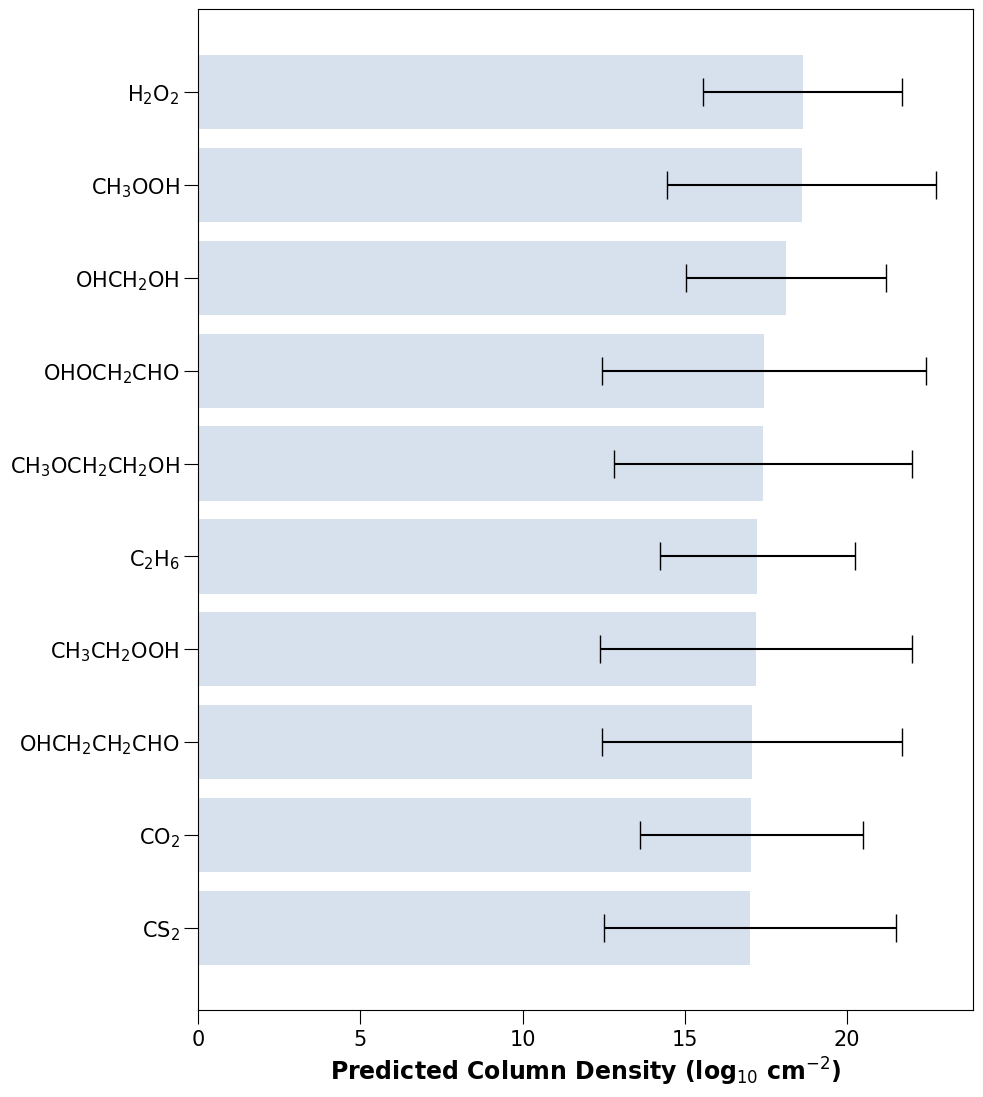

In [10]:
'''
This code cell creates the bar chart presented in Figure 3

'''

fullPath = os.path.join(os.getcwd(), 'prediction_results.csv')
full = pd.read_csv(fullPath)

smiles = list(full['smiles'])[-10:]
predictions = list(full['predicted CD'])[-10:]
sd = list(full['sd'])[-10:]
x_pos = np.arange(len(smiles))

hfont = {'fontname':'Arial'}
molecules = ['H$_2$O$_2$', 'CH$_3$OOH', 
             'OHCH$_2$OH', 'OHOCH$_2$CHO','CH$_3$OCH$_2$CH$_2$OH', 'C$_2$H$_6$', 'CH$_3$CH$_2$OOH','OHCH$_2$CH$_2$CHO','CO$_2$', 'CS$_2$']


molecules.reverse()

fig, ax = plt.subplots(figsize = (10,13))
ax.barh(x_pos, predictions, color = 'lightsteelblue', xerr=sd, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Predicted Column Density (log$_{10}$ cm$^{-2}$)', fontsize = 17, fontweight = 'bold')
ax.set_yticks(x_pos)
ax.tick_params(axis="y", direction="out", labelsize=15, length=10, labeltop = False)

ax.tick_params(axis="x", direction="out", labelsize=15, length=10, labeltop = False)
ax.set_yticklabels(molecules)

plt.show()


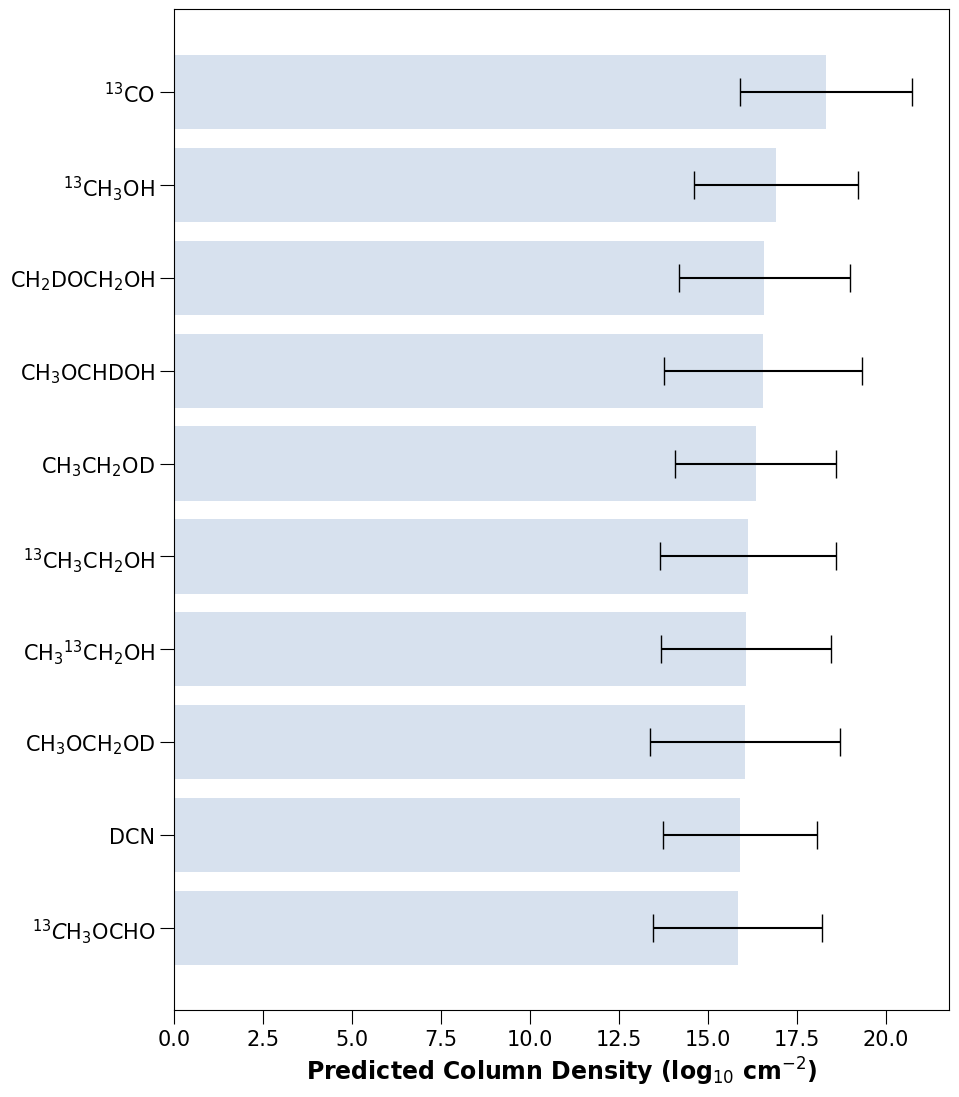

In [11]:
'''
This code cell creates the bar chart presented in Figure 6

'''

fullPath = os.path.join(os.getcwd(), 'isotopologue_prediction_results.csv')
full = pd.read_csv(fullPath)

smiles = list(full['smiles'])[-10:]
predictions = list(full['predicted CD'])[-10:]
sd = list(full['sd'])[-10:]
x_pos = np.arange(len(smiles))

hfont = {'fontname':'Arial'}




iso_molecules = ['$^{13}$CO', '$^{13}$CH$_3$OH','CH$_2$DOCH$_2$OH', 'CH$_3$OCHDOH', 'CH$_3$CH$_2$OD', 
                '$^{13}$CH$_3$CH$_2$OH', 'CH$_3$$^{13}$CH$_2$OH', 'CH$_3$OCH$_2$OD', 'DCN', '$^{13}C$H$_3$OCHO']


iso_molecules.reverse()



fig, ax = plt.subplots(figsize = (10,13))
ax.barh(x_pos, predictions, color = 'lightsteelblue', xerr=sd, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xlabel('Predicted Column Density (log$_{10}$ cm$^{-2}$)', fontsize = 17, fontweight = 'bold')
ax.set_yticks(x_pos)
ax.tick_params(axis="y", direction="out", labelsize=15, length=10, labeltop = False)

ax.tick_params(axis="x", direction="out", labelsize=15, length=10, labeltop = False)
ax.set_yticklabels(iso_molecules)

plt.show()